<a href="https://colab.research.google.com/github/maiam6242/Facial_Blur/blob/master/Facial_Blur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drawing Recognition with Convolutional Neural Networks

Colin Snow and Maia Materman


#### Our Application

For this project, we hoped to create a machine learning model that was able to recognize drawings from a user. When we were framing this project, we thought that it would be interesting to look at it as a software we could give to kids to allow them to associate words with corresponding images. 


#### Our Model

Our model is outlined below. Essentially, we took a dataset from google Quick Draw and trained a Convolutional Neural Network on it. We also incorporated data from actual users we asked to engage in the same exercise the dataset did. 

##### Data
We began by importing required python modules and our datasets from google and then converting them to numpy arrays. We imported four datasets, each containing one type of image. We chose to use datasets of tower, bear, airplane, broccoli, dog, and broom images. This was mostly based on which ones we thought looked good or funny, but this selection also gives a good representation of living and static items and geometric and organic shapes.


In [9]:
!pip install torchviz
# !CUDA_LAUNCH_BLOCKING=1
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchviz import make_dot
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim


import matplotlib.pyplot as plt
import numpy as np # we always love numpy
import time
import gdown
import pandas as pd


gdown.download('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/The%20Eiffel%20Tower.npy', 'eiffeltower.npy', False)
gdown.download('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bear.npy', 'bear.npy', False)
gdown.download('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy', 'airplane.npy', False)
gdown.download('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/broccoli.npy', 'broccoli.npy', False)
gdown.download('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy', 'dog.npy', False)
gdown.download('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/broom.npy', 'broom.npy', False)

Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/The%20Eiffel%20Tower.npy
To: /content/eiffeltower.npy
100%|██████████| 106M/106M [00:00<00:00, 191MB/s] 
Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bear.npy
To: /content/bear.npy
100%|██████████| 106M/106M [00:00<00:00, 187MB/s] 
Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy
To: /content/airplane.npy
100%|██████████| 119M/119M [00:00<00:00, 186MB/s] 
Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/broccoli.npy
To: /content/broccoli.npy
100%|██████████| 104M/104M [00:00<00:00, 196MB/s]
Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy
To: /content/dog.npy
100%|██████████| 119M/119M [00:00<00:00, 196MB/s]
Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/broom.npy
To: /content/broo

'broom.npy'

In [0]:
tower = np.load('eiffeltower.npy') #type = 1
bear = np.load('bear.npy') # type = 0
airplane = np.load('airplane.npy')
broccoli = np.load('broccoli.npy')
dog = np.load('dog.npy')
broom = np.load('broom.npy')



##### Visualization

Because our data was an array of numpy arrays, we displayed an image as an index of a list using matplotlib.

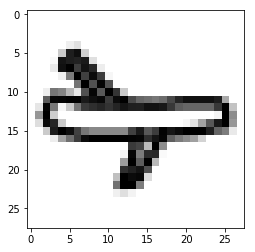

In [11]:
import matplotlib.pyplot as plt
import numpy as np

X = airplane[750]
X = np.resize(X,(28,28))
X = np.invert(X)
plt.imshow(X, cmap="gray")
plt.show()

##### Our Dataset

In addition to the google dataset, we decided to create our own data to see how changing the method of collection affected the result. We collected a full set of 6 images from 14 different people around Olin for a total of 84 new test images. We recorded the data in photoshop by giving each participant 20 seconds to draw the required image on a 28 x 28 pixel grid. We saved each of these images named by type and then imported them below to create a numpy array for each of these datasets as well.

In [12]:
from PIL import Image
import glob

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])


airplane_list = []
for filename in glob.glob('airplane*.jpg'):
    im=Image.open(filename).resize((28,28))
    airplane_list.append( np.array((np.invert(np.array(im)))))

broom_list = []
for filename in glob.glob('broom*.jpg'):
    im=Image.open(filename).resize((28,28))
    broom_list.append( np.array((np.invert(np.array(im)))))

bear_list = []
for filename in glob.glob('bear*.jpg'):
    im=Image.open(filename).resize((28,28))
    bear_list.append( np.array((np.invert(np.array(im)))))

broccoli_list = []
for filename in glob.glob('broccoli*.jpg'):
    im=Image.open(filename).resize((28,28))
    broccoli_list.append( np.array((np.invert(np.array(im)))))

tower_list = []
for filename in glob.glob('tower*.jpg'):
    im=Image.open(filename).resize((28,28))
    tower_list.append( np.array((np.invert(np.array(im)))))

dog_list = []
for filename in glob.glob('dog*.jpg'):
    im=Image.open(filename).resize((28,28))
    dog_list.append( np.array((np.invert(np.array(im)))))

dog_list = np.array(dog_list)
broccoli_list = np.array(broccoli_list)
bear_list = np.array(bear_list)
broom_list = np.array(broom_list)
airplane_list = np.array(airplane_list)
print(len(tower_list))
tower_list = np.array(tower_list)

14


##### Tensor Creation

In order to use our data, we first needed to load it into pytorch and assign keys to each image. This is so that the model knows the correct identity of each picture. We did this by creating a QuickDrawData class that took an arbitry number of numpy arrays and stacked them all together while giving each a unique key identifier. We used this same class to load both the google data and our own.

In [0]:
from torch.utils.data import Dataset
from torch.utils.data import random_split

import torch

class QuickDrawData(Dataset):
    def __init__(self, *args):
        super(QuickDrawData, self).__init__()
        count = 0
        # self.data = np.empty(args[0].shape, dtype=int)
        # self.targets = np.empty(args[0].shape, dtype=int)
        self.classes = []
        for arg in args:
          # print(str(arg))
          if type(arg) == str:
            self.classes += arg
          else:
            if count == 0:
              self.data = np.array(arg)
              self.targets = np.array(0*np.ones(arg.shape[0], dtype = int))
            else:
              self.data = np.vstack((self.data, arg))
              self.targets = np.hstack((self.targets, int(count)*np.ones(arg.shape[0], dtype = int)))
            count+=1
    
    def __len__(self):
        return self.targets.shape[0]
    
    def __getitem__(self, index):
        # print(self.data[index, :])
        # print(type(self.data[index, :]))
        # print(np.size(self.data[index, :]))
        return torch.FloatTensor(self.data[index, :].reshape((28, 28))).unsqueeze(0), int(self.targets[index])

quick_draw_data = QuickDrawData(tower, bear, airplane, broccoli, dog, broom, 'tower', 'bear', 'airplane', 'brocolli', 'dog', 'broom')
testdata = QuickDrawData(np.array(tower_list), np.array(bear_list), np.array(airplane_list), np.array(broccoli_list), np.array(dog_list), np.array(broom_list), 'tower', 'bear', 'airplane', 'brocolli', 'dog', 'broom')

##### Train/Test split
Because our own data is very limited, we used a portion of the QuickDraw data as our testing set. We split the dataset into 90% training and 10% test, assigning each image randomly to the sets to avoid any ordering bias.

In [0]:
x = int(len(quick_draw_data)*.9) 
train, test = random_split(quick_draw_data, [x,(len(quick_draw_data) - x)])

##### Assigning samplers

In order to run batches through the model, pytorch needed a sampler class which takes images from the sets and runs them through the model. We created a sampler class for the training and testing sets as these needed to be used by the model while it was being trained. We also created another test set, test_set_2, which represented the data we collected ourselves. 

In [0]:
# Data set information
image_dims = 1, 28, 28
n_training_samples = len(train) # How many training images to use
n_test_samples = len(test) # How many test images to use
classes = ('tower', 'bear', 'airplane', 'brocolli', 'dog', 'broom')

# Load the training set
train_set = train
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

#Load the test set
test_set = test
test_set2 = testdata
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
test_sampler2 = SubsetRandomSampler(np.arange(84, dtype=np.int64))

##### Defining CNN
We then needed to define our convolutional neural network. We needed to specify layers of our model, both in the type of layer and the size. We utilized two 2D convolutions, two maxpool layers, three fully connected layers, a batch norm per convolution and a ReLu activation function for every layer except the last, which used a soft max. Those generally took a number of kernels and kernel size or a layer size as arguments. 

Once we defined all of the layers, we ordered them in a forward function. That fucntion is actually what determined the structure of our model, and was also visualized in the code below. 

In [0]:
class MyCNN(nn.Module):
  
  def __init__(self):
    super(MyCNN, self).__init__()
    
    # Defining the number of kernels and the size of the fully convolutional layers
    num_kernels = 16
    fcl_size = 256
    fcl_size2 = 128
    fcl_size3 = 64
    
    # Defining the layers of our model
    self.conv1 = nn.Conv2d(1, num_kernels, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
    self.conv2 = nn.Conv2d(num_kernels, num_kernels*2, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
    self.maxpool_output_size1 = int(num_kernels*(image_dims[1]/2) * (image_dims[2]/2))
    self.maxpool_output_size2 = int(num_kernels*(image_dims[1]/4) * (image_dims[2]/4)*2)
    self.batchnorm1 = nn.BatchNorm2d(num_kernels)
    self.batchnorm2 = nn.BatchNorm2d(num_kernels*2)
    self.batchnorm3 = nn.BatchNorm1d(fcl_size)
    self.batchnorm4 = nn.BatchNorm1d(fcl_size2)
    self.batchnorm5 = nn.BatchNorm1d(fcl_size3)
    self.fc1 = nn.Linear(1568, fcl_size)
    self.activation_func = torch.nn.ReLU()
    self.fc2 = nn.Linear(fcl_size, fcl_size2)
    self.fc4 = nn.Linear(fcl_size2, fcl_size3)
    self.activation_func = torch.nn.ReLU()
    fc3_size = len(classes)
    self.fc3 = nn.Linear(fcl_size3, fc3_size)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.activation_func(x)
    x = self.batchnorm1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.activation_func(x)
    x = self.batchnorm2(x)
    x = self.pool2(x)
    x = self.activation_func(x)
    x = x.view(-1, self.maxpool_output_size2)
    x = self.fc1(x)
    x = self.activation_func(x)
    x = self.fc2(x)
    x = self.activation_func(x)
    x = self.fc4(x)
    x = self.activation_func(x)
    x = self.fc3(x)
    x = torch.nn.functional.log_softmax(x)
    return x

  def get_loss(self, learning_rate):
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    return loss, optimizer
  

In [0]:
net = MyCNN()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


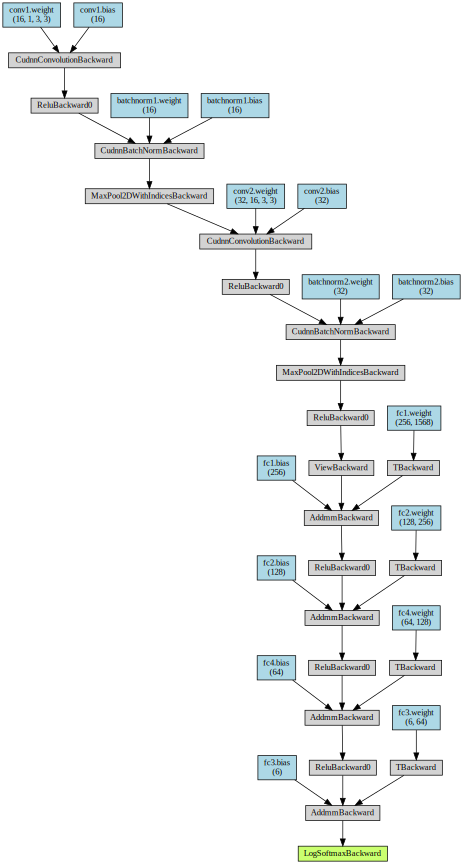

In [18]:
def visualize_network(net):
    # Visualize the architecture of the model
    # We need to give the net a fake input for this library to visualize the architecture
    fake_input = Variable(torch.zeros((1, image_dims[0], image_dims[1], image_dims[2]))).to(device)
    outputs = net(fake_input)
    # Plot the DAG (Directed Acyclic Graph) of the model
    return make_dot(outputs, dict(net.named_parameters()))

# Define what device we want to use
device = 'cuda' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
net = MyCNN()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)
# This plots a nice visualization of our network as seen below
visualize_network(net)

##### Training Our Model
In order to actually use our model, we needed to train it. Training a model turned out to be a time and computationally intensive project. To begin, we needed to define some parameters which determined the way the model runs like the number of epochs and the batch size. Using the batch sizes we defined, we sorted our data into different batches which we utilized to train and test the model. We then created variables to track certain things about the way that our model was performing like the training and test losses and history. After that, we looped through the number of epochs that we specified earlier. In this loop, we ran the training data through our model, calculating the inaccuracies (loss) at each point in the process. Once that happened, we ran our test set through the model that was trained on the previous data. That allowed us to determine an accuracy percentage on the test data at that point. This process was repeated a number of times (as per the number of epochs we defined), and then we summed the total loss in our model and time our code took to execute. 

After getting those metrics, we were able to plot the loss of our function over the number of training and test images which we had, giving us a way to see how our loss was changing with more data. That visualization is displayed below.

In [0]:
# Define training parameters
batch_size = 32
learning_rate = 1e-2
n_epochs = 5

# Get our data into the mini batch size that we defined
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, sampler=train_sampler, num_workers = 2)
test_loader2 = torch.utils.data.DataLoader(testdata, batch_size = 84, sampler=test_sampler2, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, sampler=test_sampler, num_workers = 2)

def train_model(net):
    """ Train a the specified network.

        Outputs a tuple with the following four elements
        train_hist_x: the x-values (batch number) that the training set was 
            evaluated on.
        train_loss_hist: the loss values for the training set corresponding to
            the batch numbers returned in train_hist_x
        test_hist_x: the x-values (batch number) that the test set was 
            evaluated on.
        test_loss_hist: the loss values for the test set corresponding to
            the batch numbers returned in test_hist_x
    """ 
    loss, optimizer = net.get_loss(learning_rate)
    
    # Define some parameters to keep track of metrics
    print_every = 200
    idx = 0
    train_hist_x = []
    train_loss_hist = []
    test_hist_x = []
    test_loss_hist = []
    training_start_time = time.time()

    # Loop for n_epochs
    for epoch in range(n_epochs):
        running_loss = 0.0
        start_time = time.time()
        for i, data in enumerate(train_loader, 0):
            # Get inputs in right form
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

            # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            
            # Compute the loss and find the loss with respect to each parameter of the model
            loss_size = loss(outputs, labels)
            loss_size.backward()
            
            # Change each parameter with respect to the recently computed loss.
            optimizer.step()

            # Update statistics
            running_loss += loss_size.data.item()
            
            # Print every 20th batch of an epoch
            if (i % print_every) == print_every-1:
                print("Epoch {}, Iteration {}\t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
                
                # Reset running loss and time
                train_loss_hist.append(running_loss / print_every)
                train_hist_x.append(idx)
                running_loss = 0.0
                start_time = time.time()
            idx += 1

        # At the end of the epoch, do a pass on the test set
        total_test_loss = 0
        for inputs, labels in test_loader:
            # Wrap tensors in Variables
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

            # Forward pass
            test_outputs = net(inputs)
            test_loss_size = loss(test_outputs, labels)
            total_test_loss += test_loss_size.data.item()
        # Calculating the total loss over the whole system
        test_loss_hist.append(total_test_loss / len(test_loader))
        test_hist_x.append(idx)
        print("Validation loss = {:.2f}".format(
            total_test_loss / len(test_loader)))
    # Calculating the time that it took to train our model
    print("Training finished, took {:.2f}s".format(
        time.time() - training_start_time))
    return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

In [0]:
train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(net)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1, Iteration 200	 train_loss: 0.73 took: 2.23s
Epoch 1, Iteration 400	 train_loss: 0.50 took: 1.94s
Epoch 1, Iteration 600	 train_loss: 0.44 took: 2.02s
Epoch 1, Iteration 800	 train_loss: 0.43 took: 1.98s
Epoch 1, Iteration 1000	 train_loss: 0.39 took: 1.94s
Epoch 1, Iteration 1200	 train_loss: 0.38 took: 2.01s
Epoch 1, Iteration 1400	 train_loss: 0.36 took: 1.92s
Epoch 1, Iteration 1600	 train_loss: 0.37 took: 1.97s
Epoch 1, Iteration 1800	 train_loss: 0.37 took: 1.95s
Epoch 1, Iteration 2000	 train_loss: 0.37 took: 1.91s
Epoch 1, Iteration 2200	 train_loss: 0.35 took: 1.92s
Epoch 1, Iteration 2400	 train_loss: 0.34 took: 2.00s
Epoch 1, Iteration 2600	 train_loss: 0.35 took: 1.90s
Epoch 1, Iteration 2800	 train_loss: 0.32 took: 1.99s
Epoch 1, Iteration 3000	 train_loss: 0.34 took: 2.15s
Epoch 1, Iteration 3200	 train_loss: 0.33 took: 2.20s
Epoch 1, Iteration 3400	 train_loss: 0.34 took: 2.28s
Epoch 1, Iteration 3600	 train_loss: 0.34 took: 2.22s
Epoch 1, Iteration 3800	 train_l

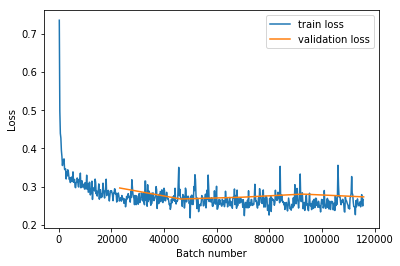

In [0]:
# Plot the loss from above
plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.show()

##### Testing Our Model
Once the model was trained, we got to actually test it! As mentioned above, we tested with both a training set from the set of original data we downloaded as well as with data we collected. This was not as much of a challenge computationally as we first assumed it would be. Essentially, we first formatted our inputs, then rant the various batches through our model. After that, it was a matter of simply taking the percentage of images which the model selected correctly in relation to the total number of pictures. 

We were also able to get the accuracy of our model picture by picture, basically, we chose images an image and the model output a guess and the correct value. To do this, we ran the image through the trained network from above. One point that was interesting from our image by image analysis is that we included the confidence of the model in its prediction. We calculated that by taking the maximum of all of the confidence metrics which the model had and dividing by the sum of the confidences.

In [0]:
def get_accuracy(net, loader):
    n_correct = 0
    n_total = 0
    for i, data in enumerate(loader, 0):
        # Get inputs in right form
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        outputs = net(inputs)
        n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
        n_total += labels.shape[0]
    return n_correct/n_total
print("Train accuracy is", get_accuracy(net, train_loader))
print("Test accuracy is", get_accuracy(net, test_loader))
print("Test accuracy our data is", get_accuracy(net, test_loader2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train accuracy is 0.9139159921597002
Test accuracy is 0.9095614141659579
Test accuracy our data is 0.7023809523809523


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


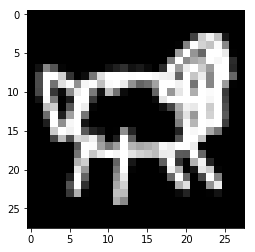

Prediction is:  4
Actual is:  4
Weights are:  [[-4.933739   -1.9634188  -2.8627555  -4.373681   -0.25245857 -5.1467133 ]]


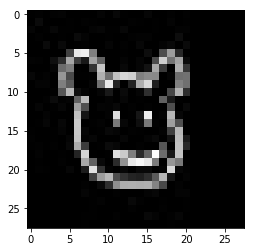

Prediction is:  1
Actual is:  1
Weights are:  [[-7.195395   -0.53327596 -5.0945406  -5.306212   -0.91400886 -7.4776554 ]]


In [0]:
def examine_label(idx):
    image, label = test_set[idx]
    class_scores = net(Variable(image.unsqueeze(0)).to(device))
    prediction = np.argmax(class_scores.cpu().detach().numpy())
    confidence = class_scores.cpu().detach().numpy()
    plt.imshow(image.squeeze(), cmap='gray')
    plt.show()
    print('Prediction is: ', prediction)
    print('Actual is: ', label)
    print('Weights are: ', confidence)

def examine_labelours(idx):
    image, label = test_set2[idx]
    class_scores = net(Variable(image.unsqueeze(0)).to(device))
    prediction = np.argmax(class_scores.cpu().detach().numpy())
    confidence = class_scores.cpu().detach().numpy()
    plt.imshow(image.squeeze(), cmap='gray')
    plt.show()
    print('Prediction is: ',prediction)
    print('Actual is: ',label)
    print('Weights are: ', confidence)

examine_label(7)
examine_labelours(23)

#### The Results and Bigger Picture

Our model didn't really have too many big picture applications. If a sketch of a broom is misidentified as a sketch of broccoli, at the end of the day not too many people care very much. With that said, though, to think of this in terms of our broader application, teaching a child that the thing that they drew is incorrect or that what they sketched is correct when it shouldn't be is also not desirable.

Unfortunately with our accuracy on the test images that we collected averaging around 70%, we would not feel very confident giving this algorithm to anyone who wanted to use it with potential users. We enjoyed making it and learned a lot, but to give it out to people to use, we would need to do a lot more to improve the accuracy on user data. On a more positive note, we were able to get our test data accuracy up to around 90%, which was awesome. 